In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/VZ_Network_Priority/GRU_2nd_dec/user_activity_pattern_updated_v6_30_nov.csv")  # Replace with your file path

# Convert timestamp to datetime and sort the data
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

# Aggregate data for hourly usage
data_agg = data.groupby(['timestamp', 'service_group', 'service_name'])['usage_minutes'].sum().reset_index()

# Pivot the data to create a time series for each service
pivoted_data = data_agg.pivot_table(
    index='timestamp', columns=['service_group', 'service_name'], values='usage_minutes', fill_value=0
)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivoted_data)

# Create sequences for GRU
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., 24 hours)
sequence_length = 24
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (36526, 24, 16), y_train shape: (36526, 16)
X_test shape: (9132, 24, 16), y_test shape: (9132, 16)


In [3]:
# Define the GRU model
model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(X_train.shape[2])  # Output layer with the number of features (services)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Adjust epochs as needed
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 0.0242 - mae: 0.0696 - val_loss: 0.0227 - val_mae: 0.0639
Epoch 2/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - loss: 0.0226 - mae: 0.0664 - val_loss: 0.0225 - val_mae: 0.0625
Epoch 3/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 0.0223 - mae: 0.0649 - val_loss: 0.0224 - val_mae: 0.0621
Epoch 4/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.0223 - mae: 0.0645 - val_loss: 0.0223 - val_mae: 0.0628
Epoch 5/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 0.0222 - mae: 0.0640 - val_loss: 0.0222 - val_mae: 0.0620
Epoch 6/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0220 - mae: 0.0633 - val_loss: 0.0222 - val_mae: 0.0619
Epoch 7/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0221 - mae: 0.0635 - val_loss: 0.0222 - val_mae: 0.0616
Epoch 8/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0220 - mae: 0.0631 - val_loss: 0.0221 - val_mae: 0.0615
Epoch 9/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 

In [4]:
# Generate future predictions
def predict_future(model, input_data, future_steps):
    predictions = []
    current_input = input_data[-1]  # Start from the last available data
    for _ in range(future_steps):
        prediction = model.predict(current_input[np.newaxis, :, :])
        predictions.append(prediction[0])
        current_input = np.vstack([current_input[1:], prediction])  # Update the input with the prediction
    return np.array(predictions)

# Predict the next 15 days (15 * 24 = 360 hourly steps)
future_steps = 15 * 24
future_predictions = predict_future(model, X_test, future_steps)

# Inverse transform the predictions to get the actual scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Generate future timestamps
last_timestamp = pivoted_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]

# Combine predictions into a DataFrame
future_df = pd.DataFrame(future_predictions_rescaled, index=future_timestamps, columns=pivoted_data.columns)
future_df.reset_index(inplace=True)
future_df.rename(columns={"index": "timestamp"}, inplace=True)

# Save predictions to CSV
future_df.to_csv("future_predictions.csv", index=False)
print("Future predictions saved to 'future_predictions.csv'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

<ipython-input-4-44bf3196f0ad>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]


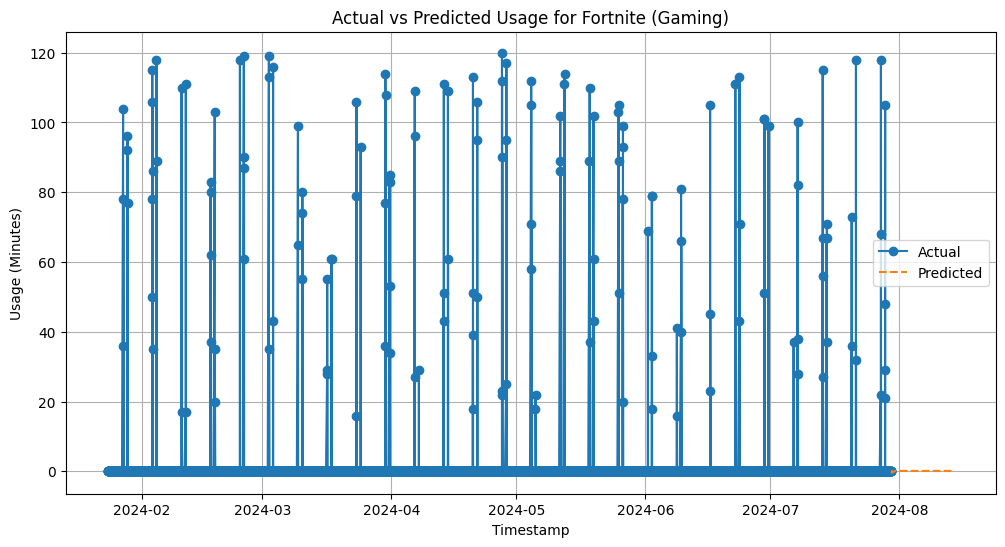

In [5]:
# Plot actual vs predicted usage trends (hourly)
plt.figure(figsize=(12, 6))

# Select a service group and name (e.g., Gaming - Fortnite)
service_group = "Gaming"
service_name = "Fortnite"

# Plot actual data
plt.plot(
    pivoted_data.index[-len(y_test):],
    scaler.inverse_transform(y_test)[:, pivoted_data.columns.get_loc((service_group, service_name))],
    label="Actual",
    marker='o'
)

# Plot predicted data
plt.plot(
    future_timestamps,
    future_predictions_rescaled[:, pivoted_data.columns.get_loc((service_group, service_name))],
    label="Predicted",
    linestyle='--'
)

plt.title(f"Actual vs Predicted Usage for {service_name} ({service_group})")
plt.xlabel("Timestamp")
plt.ylabel("Usage (Minutes)")
plt.legend()
plt.grid()
plt.show()


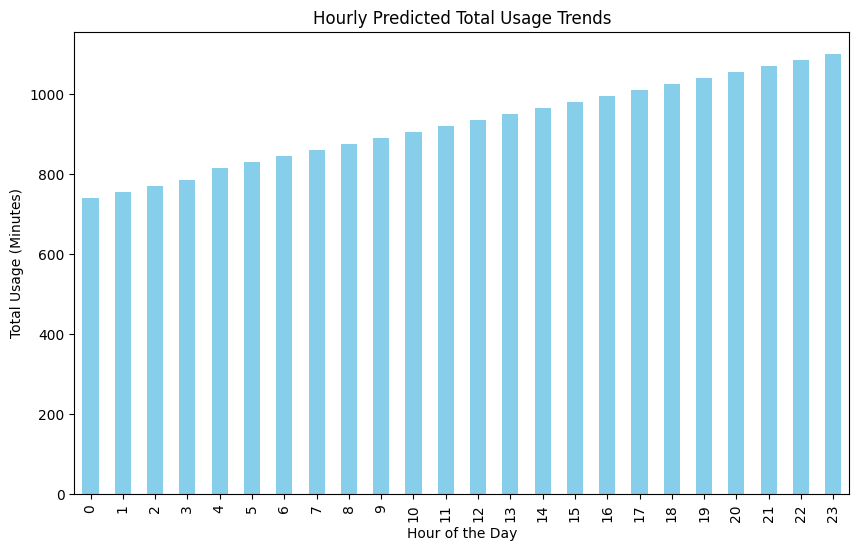

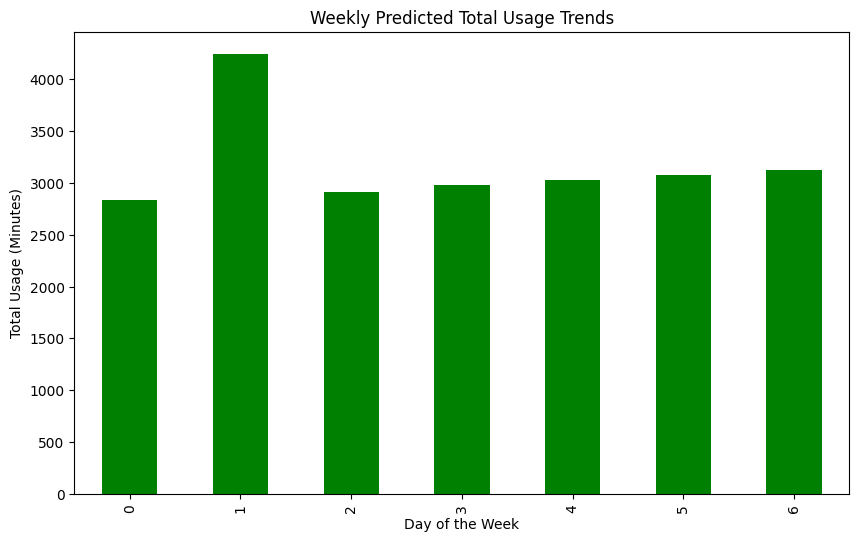

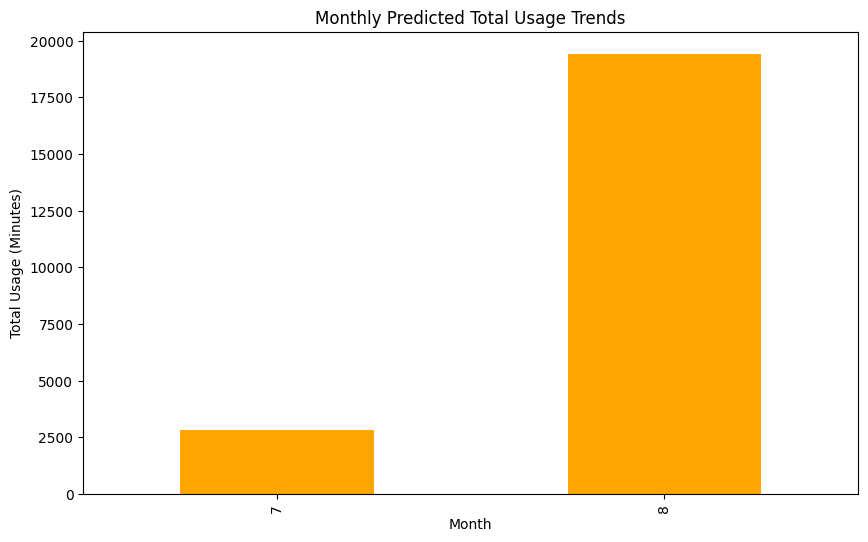

In [8]:
# Add a total usage column by summing across all services for each timestamp
future_df['total_usage'] = future_df.iloc[:, 1:].sum(axis=1)

# Hourly trends
hourly_trends = future_df.groupby('hour')['total_usage'].sum()
plt.figure(figsize=(10, 6))
hourly_trends.plot(kind='bar', color='skyblue')
plt.title("Hourly Predicted Total Usage Trends")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Usage (Minutes)")
plt.show()

# Weekly trends
weekly_trends = future_df.groupby('day_of_week')['total_usage'].sum()
plt.figure(figsize=(10, 6))
weekly_trends.plot(kind='bar', color='green')
plt.title("Weekly Predicted Total Usage Trends")
plt.xlabel("Day of the Week")
plt.ylabel("Total Usage (Minutes)")
plt.show()

# Monthly trends
monthly_trends = future_df.groupby('month')['total_usage'].sum()
plt.figure(figsize=(10, 6))
monthly_trends.plot(kind='bar', color='orange')
plt.title("Monthly Predicted Total Usage Trends")
plt.xlabel("Month")
plt.ylabel("Total Usage (Minutes)")
plt.show()


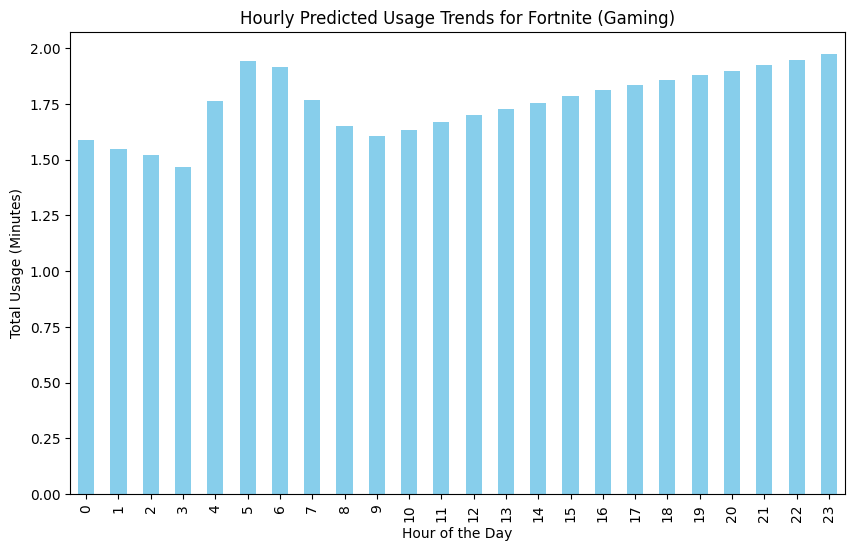

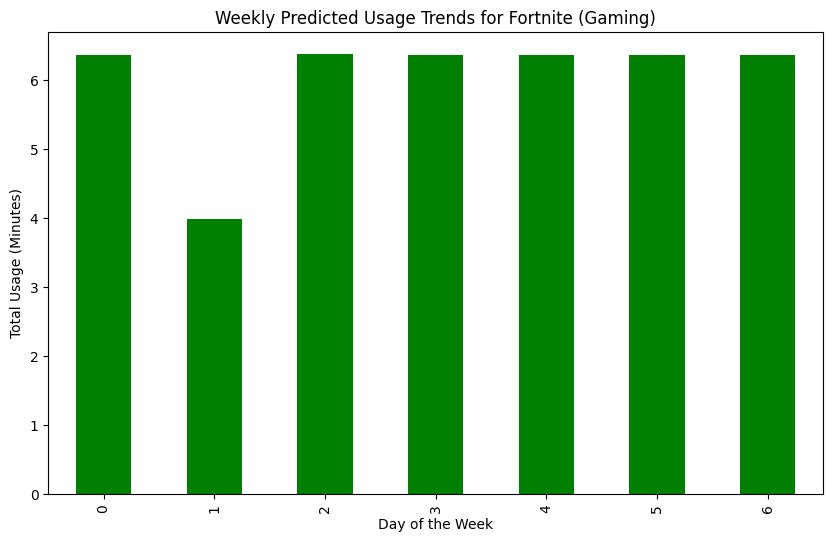

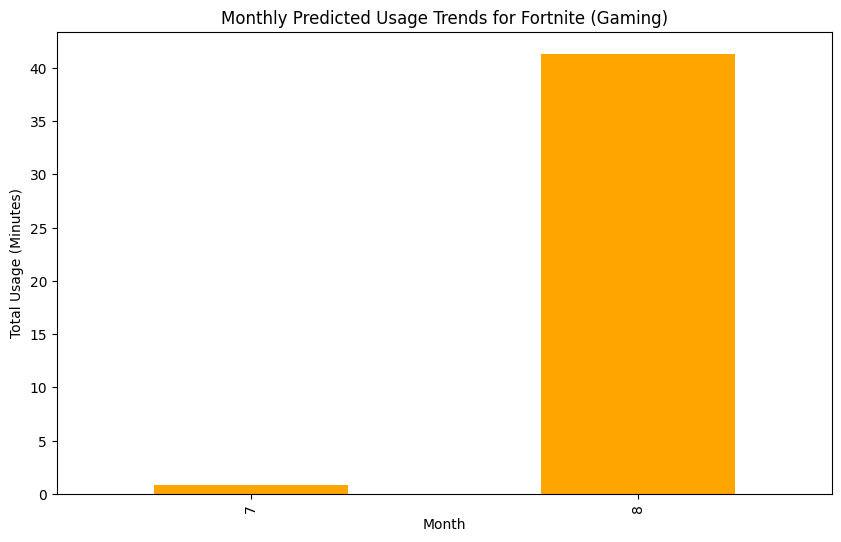

In [9]:
# Extract predictions for a specific service
service_group = "Gaming"
service_name = "Fortnite"
service_index = pivoted_data.columns.get_loc((service_group, service_name))

# Add a specific service usage column to future_df
future_df['service_usage'] = future_predictions_rescaled[:, service_index]

# Hourly trends
hourly_trends = future_df.groupby('hour')['service_usage'].sum()
plt.figure(figsize=(10, 6))
hourly_trends.plot(kind='bar', color='skyblue')
plt.title(f"Hourly Predicted Usage Trends for {service_name} ({service_group})")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Usage (Minutes)")
plt.show()

# Weekly trends
weekly_trends = future_df.groupby('day_of_week')['service_usage'].sum()
plt.figure(figsize=(10, 6))
weekly_trends.plot(kind='bar', color='green')
plt.title(f"Weekly Predicted Usage Trends for {service_name} ({service_group})")
plt.xlabel("Day of the Week")
plt.ylabel("Total Usage (Minutes)")
plt.show()

# Monthly trends
monthly_trends = future_df.groupby('month')['service_usage'].sum()
plt.figure(figsize=(10, 6))
monthly_trends.plot(kind='bar', color='orange')
plt.title(f"Monthly Predicted Usage Trends for {service_name} ({service_group})")
plt.xlabel("Month")
plt.ylabel("Total Usage (Minutes)")
plt.show()


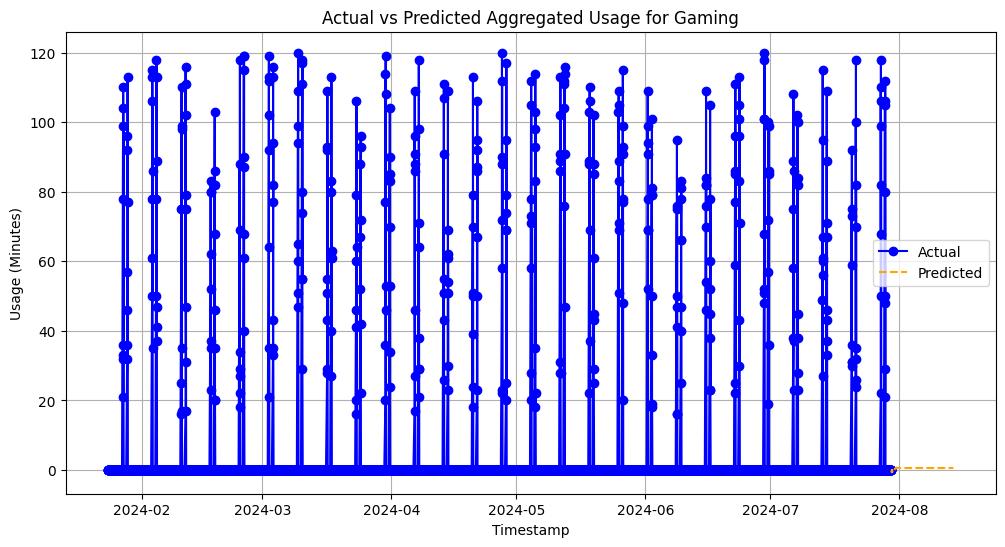

In [10]:
# Visualize aggregated trends for a service group
def plot_group_trends(service_group, y_test, future_predictions_rescaled, future_timestamps, pivoted_data):
    # Get column indices for the selected group
    group_columns = [col for col in pivoted_data.columns if col[0] == service_group]
    group_indices = [pivoted_data.columns.get_loc(col) for col in group_columns]

    # Aggregate actual and predicted data for the group
    actual_data = scaler.inverse_transform(y_test)[:, group_indices].sum(axis=1)
    predicted_data = future_predictions_rescaled[:, group_indices].sum(axis=1)

    # Plot aggregated trends
    plt.figure(figsize=(12, 6))
    plt.plot(
        pivoted_data.index[-len(actual_data):],
        actual_data,
        label="Actual",
        marker='o',
        color="blue"
    )
    plt.plot(
        future_timestamps,
        predicted_data,
        label="Predicted",
        linestyle='--',
        color="orange"
    )
    plt.title(f"Actual vs Predicted Aggregated Usage for {service_group}")
    plt.xlabel("Timestamp")
    plt.ylabel("Usage (Minutes)")
    plt.legend()
    plt.grid()
    plt.show()

# Example: Plot trends for the "Gaming" group
plot_group_trends("Gaming", y_test, future_predictions_rescaled, future_timestamps, pivoted_data)


3. Hourly, Weekly, and Monthly Trends for a Service
This code aggregates the predictions for a specific service to show trends by time.


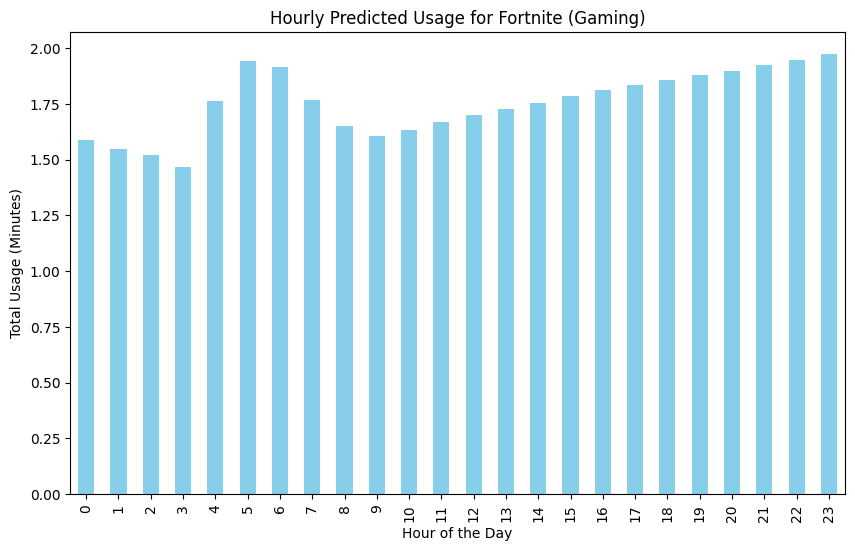

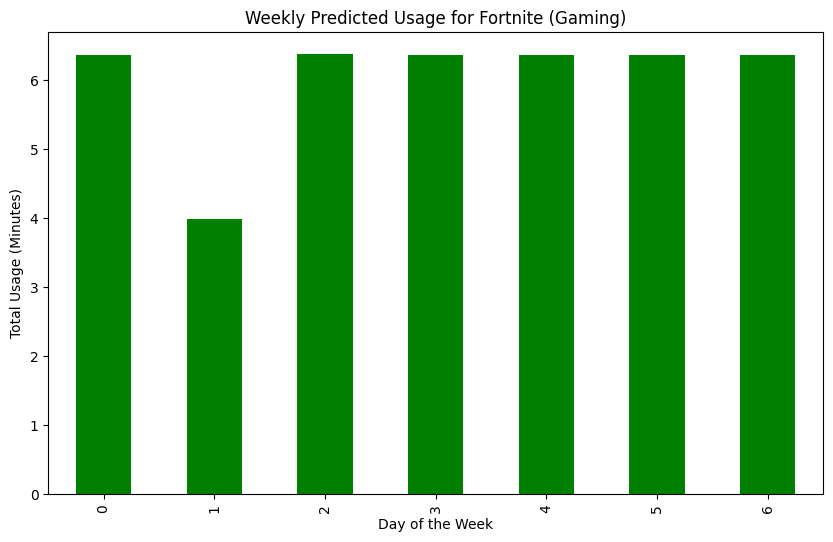

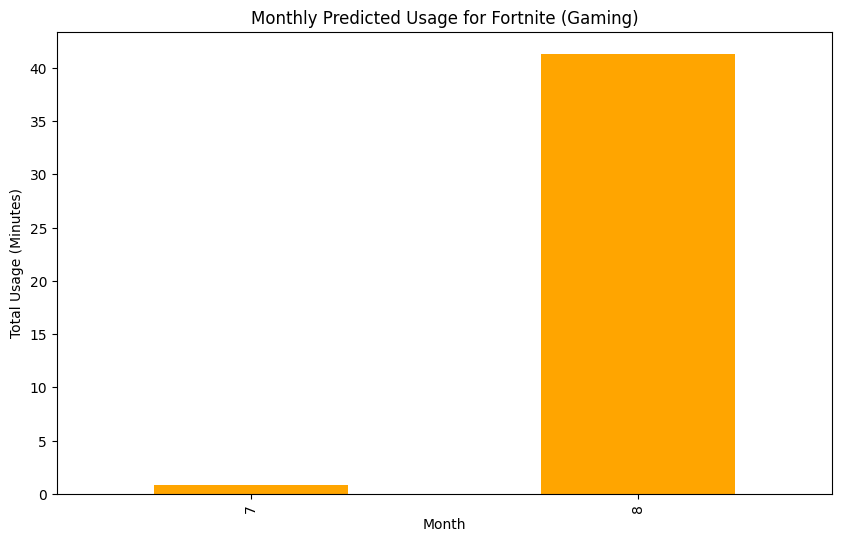

In [12]:
# Plot hourly, weekly, and monthly trends for a service
def plot_time_aggregated_trends(service_group, service_name, future_predictions_rescaled, future_timestamps, pivoted_data):
    # Find the column index for the selected service
    service_index = pivoted_data.columns.get_loc((service_group, service_name))

    # Extract predicted data for the service
    predicted_data = future_predictions_rescaled[:, service_index]
    predicted_df = pd.DataFrame({"timestamp": future_timestamps, "usage": predicted_data})

    # Aggregate by hour, week, and month
    predicted_df['hour'] = predicted_df['timestamp'].dt.hour
    predicted_df['day_of_week'] = predicted_df['timestamp'].dt.dayofweek
    predicted_df['month'] = predicted_df['timestamp'].dt.month

    # Hourly trends
    hourly_trends = predicted_df.groupby('hour')['usage'].sum()
    plt.figure(figsize=(10, 6))
    hourly_trends.plot(kind='bar', color='skyblue')
    plt.title(f"Hourly Predicted Usage for {service_name} ({service_group})")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Total Usage (Minutes)")
    plt.show()

    # Weekly trends
    weekly_trends = predicted_df.groupby('day_of_week')['usage'].sum()
    plt.figure(figsize=(10, 6))
    weekly_trends.plot(kind='bar', color='green')
    plt.title(f"Weekly Predicted Usage for {service_name} ({service_group})")
    plt.xlabel("Day of the Week")
    plt.ylabel("Total Usage (Minutes)")
    plt.show()

    # Monthly trends
    monthly_trends = predicted_df.groupby('month')['usage'].sum()
    plt.figure(figsize=(10, 6))
    monthly_trends.plot(kind='bar', color='orange')
    plt.title(f"Monthly Predicted Usage for {service_name} ({service_group})")
    plt.xlabel("Month")
    plt.ylabel("Total Usage (Minutes)")
    plt.show()

# Example: Plot hourly, weekly, and monthly trends for "Gaming - Fortnite"
plot_time_aggregated_trends("Gaming", "Fortnite", future_predictions_rescaled, future_timestamps, pivoted_data)


In [13]:
# Inverse transform the predictions to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)


Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - loss: 0.0217 - mae: 0.0620 - val_loss: 0.0220 - val_mae: 0.0605
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 63s 42ms/step - loss: 0.0217 - mae: 0.0619 - val_loss: 0.0220 - val_mae: 0.0610
Epoch 3/50


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - loss: 0.0240 - mae: 0.0695 - val_loss: 0.0226 - val_mae: 0.0626
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.0225 - mae: 0.0666 - val_loss: 0.0225 - val_mae: 0.0631
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.0224 - mae: 0.0655 - val_loss: 0.0224 - val_mae: 0.0630
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 0.0223 - mae: 0.0644 - val_loss: 0.0224 - val_mae: 0.0632
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - loss: 0.0223 - mae: 0.0643 - val_loss: 0.0223 - val_mae: 0.0620
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 0.0220 - mae: 0.0637 - val_loss: 0.0222 - val_mae: 0.0627
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0222 - mae: 0.0639 - val_loss: 0.0221 - val_mae: 0.0618
Epoch 8/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - loss: 0.0219 - mae: 0.0633 - val_loss: 0.0221 - val_mae: 0.0620
Epoch 9/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 

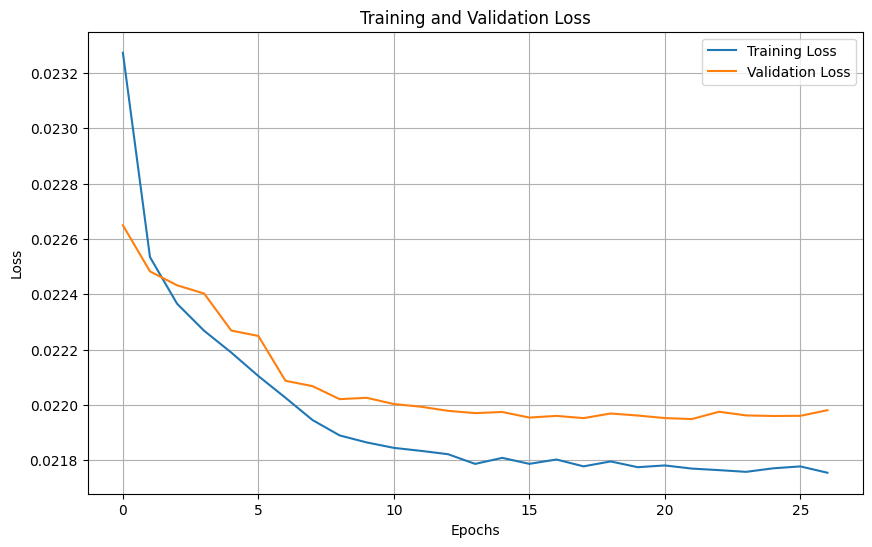

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the GRU model with Dropout layers
model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Dropout to prevent overfitting
    GRU(64, activation='relu', return_sequences=False),
    Dropout(0.2),  # Additional Dropout
    Dense(X_train.shape[2])  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add EarlyStopping callback to halt training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Maximum epochs
    batch_size=64,
    callbacks=[early_stop],  # Add EarlyStopping to callbacks
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
GRU(128, activation='relu', return_sequences=True)  # Use 128 units


In [ ]:
sequence_length = 168  # 7 days of hourly data
X, y = create_sequences(scaled_data, sequence_length)


In [ ]:
plot_service_trends("Gaming", "Fortnite", y_test, future_predictions_rescaled, future_timestamps, pivoted_data)


In [ ]:
print("Scaled Predictions:\n", future_predictions[:10])
print("Rescaled Predictions:\n", future_predictions_rescaled[:10])


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [18]:
# Predict on the test set
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)


286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


2. Visualize Actual vs Predicted Usage
Plot the actual vs predicted usage for a specific service or aggregated across services.

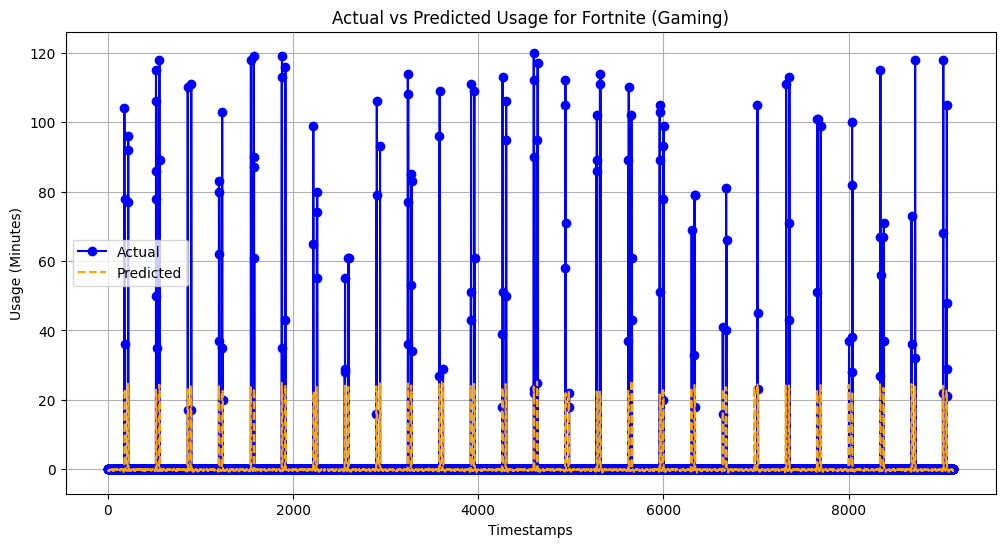

In [19]:
# Example: Plot actual vs predicted usage for a specific service
service_group = "Gaming"
service_name = "Fortnite"
service_index = pivoted_data.columns.get_loc((service_group, service_name))

# Extract actual and predicted values for the selected service
actual_values = y_test_rescaled[:, service_index]
predicted_values = predictions_rescaled[:, service_index]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual", marker='o', color="blue")
plt.plot(predicted_values, label="Predicted", linestyle='--', color="orange")
plt.title(f"Actual vs Predicted Usage for {service_name} ({service_group})")
plt.xlabel("Timestamps")
plt.ylabel("Usage (Minutes)")
plt.legend()
plt.grid()
plt.show()


3 . Evaluate Performance with Metrics
Compute the error metrics for the predictions:

Mean Absolute Error (MAE)
Root Mean Squared Error (RMSE)
Mean Absolute Percentage Error (MAPE)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


MAE: 1.71, RMSE: 8.50, MAPE: inf%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-20-90102603d353>:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100


4. Predict for the Next 15 Days
Forecast for future timestamps based on the trained GRU model:

In [21]:
# Generate predictions for the next 15 days
def predict_future(model, input_data, future_steps):
    predictions = []
    current_input = input_data[-1]  # Start from the last input
    for _ in range(future_steps):
        prediction = model.predict(current_input[np.newaxis, :, :])
        predictions.append(prediction[0])
        current_input = np.vstack([current_input[1:], prediction])  # Shift input window
    return np.array(predictions)

# Predict for the next 15 days (15 * 24 = 360 hourly steps)
future_steps = 15 * 24
future_predictions = predict_future(model, X_test, future_steps)

# Inverse transform future predictions
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Generate future timestamps
last_timestamp = pivoted_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]

# Combine future predictions into a DataFrame
future_df = pd.DataFrame(future_predictions_rescaled, index=future_timestamps, columns=pivoted_data.columns)
future_df.reset_index(inplace=True)
future_df.rename(columns={"index": "timestamp"}, inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

<ipython-input-21-267aee8c73d8>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]


5. Visualize Future Predictions
Plot the predicted usage for future timestamps:

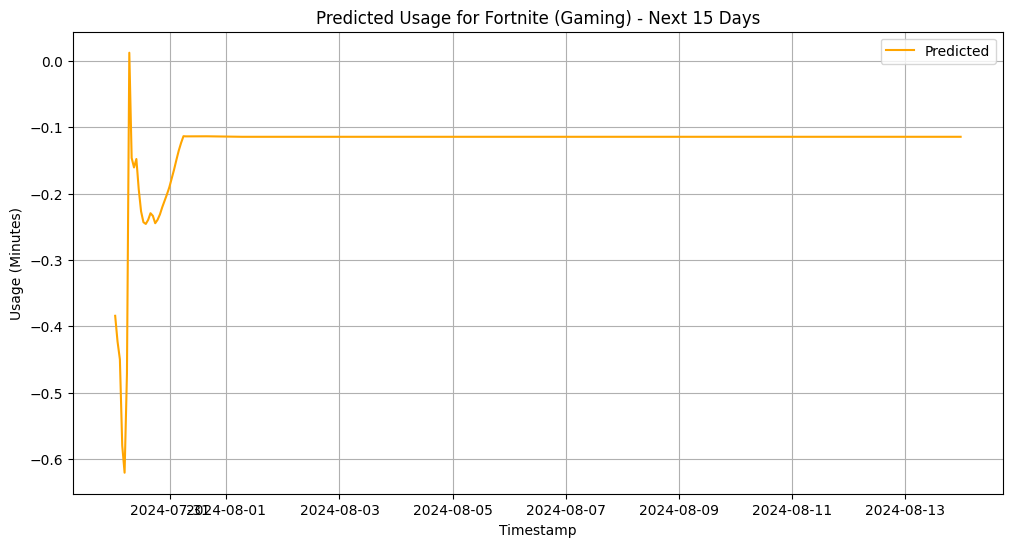

In [22]:
# Visualize future usage predictions for a specific service
plt.figure(figsize=(12, 6))
plt.plot(future_timestamps, future_predictions_rescaled[:, service_index], label="Predicted", color="orange")
plt.title(f"Predicted Usage for {service_name} ({service_group}) - Next 15 Days")
plt.xlabel("Timestamp")
plt.ylabel("Usage (Minutes)")
plt.legend()
plt.grid()
plt.show()


Steps to Improve
1. Add Temporal Features
Incorporate additional features such as:

hour_sin, hour_cos: To capture daily cycles.
day_of_week_sin, day_of_week_cos: To capture weekly cycles.

In [23]:
data['hour_sin'] = np.sin(2 * np.pi * data['timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['timestamp'].dt.dayofweek / 7)


2. Increase Model Capacity
Expand the GRU model to better learn complex patterns:
model with proper handling of GRU input and output shapes:



---



In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model
model = Sequential([
    # First GRU layer (returns sequences for the next GRU layer)
    GRU(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Second GRU layer (processes sequences and outputs final predictions)
    GRU(128, activation='relu', return_sequences=False),
    Dropout(0.2),

    # Output layer (dense layer to predict for each feature)
    Dense(X_train.shape[2])  # Number of features
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ (None, 24, 128)             │          56,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,200 (614.06 KB)

 Trainable params: 157,200 (614.06 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [27]:
# Fit the model with early stopping and dropout
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Maximum epochs
    batch_size=64,
    callbacks=[early_stop],  # EarlyStopping callback
    verbose=1
)


Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - loss: 0.0236 - mae: 0.0695 - val_loss: 0.0226 - val_mae: 0.0624
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - loss: 0.0224 - mae: 0.0654 - val_loss: 0.0224 - val_mae: 0.0619
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step - loss: 0.0221 - mae: 0.0640 - val_loss: 0.0224 - val_mae: 0.0618
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 70s 122ms/step - loss: 0.0221 - mae: 0.0635 - val_loss: 0.0222 - val_mae: 0.0616
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - loss: 0.0220 - mae: 0.0634 - val_loss: 0.0221 - val_mae: 0.0614
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - loss: 0.0219 - mae: 0.0630 - val_loss: 0.0221 - val_mae: 0.0615
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 70s 122ms/step - loss: 0.0217 - mae: 0.0625 - val_loss: 0.0221 - val_mae: 0.0611
Epoch 8/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - loss: 0.0218 - mae: 0.0625 - val_loss: 0.0220 - val_mae: 0.0610
Epoch 9/50
571/571 ━━━━━━━━━━━━━

2. Evaluate Training
Plot the loss curves to ensure the model is learning correctly:

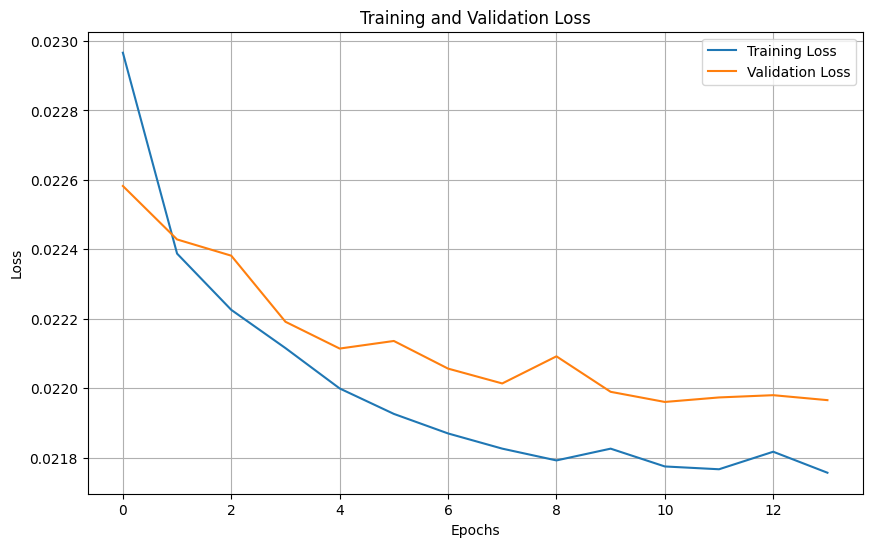

In [28]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


3. Predict and Visualize Results
After training, use the model to predict on the test set and future timestamps.


286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


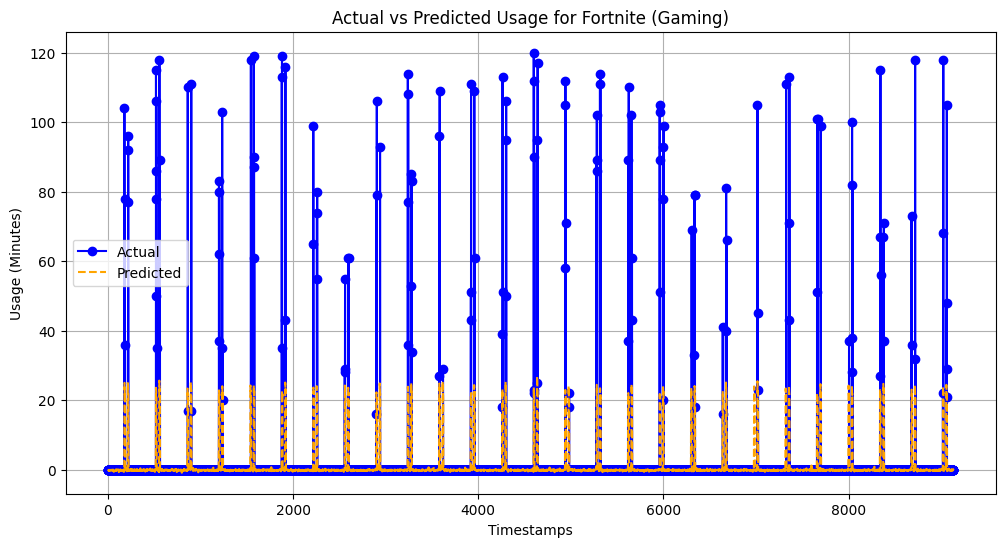

In [29]:
# Predict on the test set
predictions = model.predict(X_test)

# Rescale predictions and test values back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot actual vs predicted for a specific service
service_group = "Gaming"
service_name = "Fortnite"
service_index = pivoted_data.columns.get_loc((service_group, service_name))

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, service_index], label="Actual", marker='o', color="blue")
plt.plot(predictions_rescaled[:, service_index], label="Predicted", linestyle='--', color="orange")
plt.title(f"Actual vs Predicted Usage for {service_name} ({service_group})")
plt.xlabel("Timestamps")
plt.ylabel("Usage (Minutes)")
plt.legend()
plt.grid()
plt.show()


4. Predict Future Usage
Use the trained model to forecast future usage for the next 15 days.

In [30]:
# Predict for the next 15 days (15 * 24 = 360 hourly steps)
future_steps = 15 * 24
future_predictions = predict_future(model, X_test, future_steps)

# Rescale future predictions
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Generate future timestamps
last_timestamp = pivoted_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]

# Combine future predictions into a DataFrame
future_df = pd.DataFrame(future_predictions_rescaled, index=future_timestamps, columns=pivoted_data.columns)
future_df.reset_index(inplace=True)
future_df.rename(columns={"index": "timestamp"}, inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━

<ipython-input-30-9c53ac66a277>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]


2. Predict Usage for the Next 15 Days
We’ll generate predictions for the next 15 days (15 × 24 hours = 360 time steps).

In [31]:
# Function to predict future usage
def predict_future_usage(model, input_data, future_steps):
    predictions = []
    current_input = input_data[-1]  # Start from the last input window
    for _ in range(future_steps):
        prediction = model.predict(current_input[np.newaxis, :, :])
        predictions.append(prediction[0])
        current_input = np.vstack([current_input[1:], prediction])  # Shift input window
    return np.array(predictions)

# Predict for the next 15 days
future_steps = 15 * 24  # 15 days × 24 hours
future_predictions = predict_future_usage(model, X_test, future_steps)

# Inverse transform predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

3. Create a DataFrame with Timestamps
Generate timestamps for the next 15 days and create a DataFrame with predicted usage for all services.

In [32]:
# Generate future timestamps
last_timestamp = pivoted_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]

# Combine future predictions with timestamps
future_df = pd.DataFrame(future_predictions_rescaled, index=future_timestamps, columns=pivoted_data.columns)
future_df.reset_index(inplace=True)
future_df.rename(columns={"index": "timestamp"}, inplace=True)


<ipython-input-32-79878796873e>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_timestamps = pd.date_range(start=last_timestamp, periods=future_steps + 1, freq='H')[1:]


4. Aggregate Predictions by Day
Aggregate usage predictions for each service_group and service_name for every day.

In [35]:
# Ensure 'timestamp' column exists
future_df['timestamp'] = future_timestamps

# Add a 'date' column by extracting the date from the timestamp
future_df['date'] = future_df['timestamp'].dt.date


5. Query Predictions for a Specific Day
Filter the predictions for the given date, month, and year and return the events.



In [38]:
print(future_df.columns)
print(future_df.head())


MultiIndex([(   'timestamp',                  ''),
            (      'Gaming',          'Fortnite'),
            (      'Gaming', 'League of Legends'),
            (      'Gaming',          'Valorant'),
            (    'Shopping',            'Amazon'),
            (    'Shopping',              'Etsy'),
            (    'Shopping',              'eBay'),
            ('Social Media',          'Facebook'),
            ('Social Media',         'Instagram'),
            ('Social Media',          'LinkedIn'),
            ('Social Media',           'Twitter'),
            (    'Software',         'BlueJeans'),
            (    'Software',             'GMeet'),
            (    'Software',             'Gmail'),
            (    'Software',             'Slack'),
            (    'Software',             'WebEx'),
            (   'Streaming',           'Netflix'),
            (        'date',                  '')],
           names=['service_group', 'service_name'])
service_group           times

In [39]:
future_df['timestamp'] = future_timestamps  # Add the timestamp column


In [40]:
future_df['date'] = pd.to_datetime(future_df['timestamp']).dt.date


In [41]:
print(future_df.columns)


MultiIndex([(   'timestamp',                  ''),
            (      'Gaming',          'Fortnite'),
            (      'Gaming', 'League of Legends'),
            (      'Gaming',          'Valorant'),
            (    'Shopping',            'Amazon'),
            (    'Shopping',              'Etsy'),
            (    'Shopping',              'eBay'),
            ('Social Media',          'Facebook'),
            ('Social Media',         'Instagram'),
            ('Social Media',          'LinkedIn'),
            ('Social Media',           'Twitter'),
            (    'Software',         'BlueJeans'),
            (    'Software',             'GMeet'),
            (    'Software',             'Gmail'),
            (    'Software',             'Slack'),
            (    'Software',             'WebEx'),
            (   'Streaming',           'Netflix'),
            (        'date',                  '')],
           names=['service_group', 'service_name'])


In [46]:
# Step 2: Melt the DataFrame with correct column names
daily_predictions = future_df.melt(
    id_vars=['timestamp', 'date'],  # Retain these columns (note: no underscores)
    var_name='service',  # Combine service_group and service_name into one column
    value_name='usage'  # Rename melted column as 'usage'
)
print("After melt:", daily_predictions.head())

# Step 3: Split the 'service' column
daily_predictions[['service_group', 'service_name']] = daily_predictions['service'].str.split('_', expand=True)
print("After splitting 'service':", daily_predictions.head())

# Step 4: Aggregate by date, service_group, and service_name
daily_summary = daily_predictions.groupby(['date', 'service_group', 'service_name'])['usage'].sum().reset_index()

# Step 5: Sort the summary
daily_summary = daily_summary.sort_values(by=['date', 'usage'], ascending=[True, False])
print("Daily Summary:", daily_summary.head())


After melt:             timestamp        date          service     usage
0 2024-07-30 00:45:00  2024-07-30  Gaming_Fortnite -0.008192
1 2024-07-30 01:45:00  2024-07-30  Gaming_Fortnite -0.069237
2 2024-07-30 02:45:00  2024-07-30  Gaming_Fortnite -0.112747
3 2024-07-30 03:45:00  2024-07-30  Gaming_Fortnite -0.180803
4 2024-07-30 04:45:00  2024-07-30  Gaming_Fortnite -0.200257
After splitting 'service':             timestamp        date          service     usage service_group  \
0 2024-07-30 00:45:00  2024-07-30  Gaming_Fortnite -0.008192        Gaming   
1 2024-07-30 01:45:00  2024-07-30  Gaming_Fortnite -0.069237        Gaming   
2 2024-07-30 02:45:00  2024-07-30  Gaming_Fortnite -0.112747        Gaming   
3 2024-07-30 03:45:00  2024-07-30  Gaming_Fortnite -0.180803        Gaming   
4 2024-07-30 04:45:00  2024-07-30  Gaming_Fortnite -0.200257        Gaming   

  service_name  
0     Fortnite  
1     Fortnite  
2     Fortnite  
3     Fortnite  
4     Fortnite  
Daily Summary:          

In [48]:
# Function to get predictions for a specific day
def get_predictions_for_date(predictions_df, year, month, day):
    """
    Filter the predictions DataFrame for a specific date.

    Args:
    predictions_df (DataFrame): Aggregated predictions with columns ['date', 'service_group', 'service_name', 'usage'].
    year (int): Year of the desired date.
    month (int): Month of the desired date.
    day (int): Day of the desired date.

    Returns:
    DataFrame: Filtered predictions sorted by usage (descending).
    """
    # Create the query date
    query_date = pd.to_datetime(f"{year}-{month:02d}-{day:02d}").date()

    # Filter the DataFrame for the specific date
    events_for_day = predictions_df[predictions_df['date'] == query_date]

    # Sort by usage in descending order
    return events_for_day.sort_values(by='usage', ascending=False)

# Example: Get predictions for a specific date
year, month, day = 2024, 12, 3  # Specify the desired date
predicted_events = get_predictions_for_date(daily_summary, year, month, day)

# Display results
print(f"Predicted Service Events for {year}-{month:02d}-{day:02d}")
print(predicted_events)


Predicted Service Events for 2024-12-03
Empty DataFrame
Columns: [date, service_group, service_name, usage]
Index: []


In [49]:
# Check unique dates in daily_summary
print("Available Dates in Predictions:")
print(daily_summary['date'].unique())


Available Dates in Predictions:
[datetime.date(2024, 7, 30) datetime.date(2024, 7, 31)
 datetime.date(2024, 8, 1) datetime.date(2024, 8, 2)
 datetime.date(2024, 8, 3) datetime.date(2024, 8, 4)
 datetime.date(2024, 8, 5) datetime.date(2024, 8, 6)
 datetime.date(2024, 8, 7) datetime.date(2024, 8, 8)
 datetime.date(2024, 8, 9) datetime.date(2024, 8, 10)
 datetime.date(2024, 8, 11) datetime.date(2024, 8, 12)
 datetime.date(2024, 8, 13)]


In [50]:
# Check the last date in predictions
print("Last Date in Predictions:")
print(daily_summary['date'].max())


Last Date in Predictions:
2024-08-13


In [51]:
# Extend future timestamps to include 2024-12-03
future_steps = (pd.to_datetime("2024-12-03") - pivoted_data.index[-1]).days * 24  # Calculate steps
future_steps += 24  # Ensure full coverage

# Generate predictions for extended timestamps
future_predictions = predict_future_usage(model, X_test, future_steps)

# Reprocess predictions into daily_summary as explained earlier
# Ensure daily_summary includes 2024-12-03


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [52]:
# Debug: Print dates that match 2024-12-03
query_date = pd.to_datetime("2024-12-03").date()
print(f"Rows matching {query_date}:")
print(daily_summary[daily_summary['date'] == query_date])


Rows matching 2024-12-03:
Empty DataFrame
Columns: [date, service_group, service_name, usage]
Index: []


6. Visualize the Predictions
You can plot the predicted usage for the given day to better understand service patterns.

In [ ]:
# Plot usage for the given day
import matplotlib.pyplot as plt

def plot_daily_usage(predicted_events, date):
    plt.figure(figsize=(12, 6))
    plt.bar(predicted_events['service_name'], predicted_events['usage'], color='skyblue')
    plt.title(f"Predicted Service Usage on {date}")
    plt.xlabel("Service Name")
    plt.ylabel("Predicted Usage (Minutes)")
    plt.xticks(rotation=45, ha='right')
    plt.grid()
    plt.show()

# Plot results for the specific day
plot_daily_usage(predicted_events, f"{year}-{month:02d}-{day:02d}")
